# The Problem - Aims and Objectives
* "*Your goal is to explore and find the architecture and configuration that gives the best performance
(and is as efficient as possible). Submissions will be graded based on how well their neural networks
perform, the quality of the code, and the justification for their choices in configurations, the
reporting, and completing all the of the tasks for each problem.*"

* Create multiple Neural Nets to achieve two classification tasks predict whether a document is relevant (0) or not (1)
* Write the code as though someone else is to use it for training other models and thus would like to make minimal changes to the code and understand everything there clearly.
* Details available at [Kaggle competition page](https://www.kaggle.com/c/cs98x-dl2021-task1/data)

# Project Checklist

## 1. Framing and Bigger Picture

* How should performance be measured?
>* **F1 (task 1) and Macro-F1 (task 2) are our main performance measures**
>>* $F1 = 2\frac{p \cdot r}{p+r}\ \ \mathrm{where}\ \ p = \frac{tp}{tp+fp},\ \ r = \frac{tp}{tp+fn}$
>>* Macro-f1 score is the average F1 score across all classes - this will give a harsher punishment for exceedingly poor performance on one particular class.

## 2. Get Data and import libraries

In [2]:
# TODO: delete imported libraries which were not used
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
%matplotlib inline
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
train = pd.read_csv("/content/train.csv", na_filter = False)
test = pd.read_csv("/content/test.csv", na_filter = False)

In [5]:
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

## 3. EDA

### Target Variable Analysis

5.9% of the training documents are considered relevant.


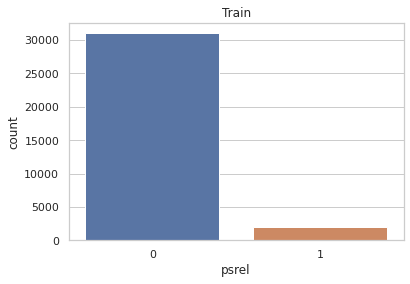

In [6]:
print('{:.1f}% of the training documents are considered relevant.'.format(100*train['psrel'].mean()))
sns.countplot(x=train['psrel'])
plt.title('Train')
plt.show()

Target is heavily imbalanced. May need to consider [sampling to manufacture a balance](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb) or some other data augmentation method.

[This kaggle notebook](https://www.kaggle.com/shahules/tackling-class-imbalance) provides some good guidance.

In [7]:
rows, cols = train.shape
print(f'There are {rows} rows and {cols} columns.\n')
train.head()

There are 33000 rows and 19 columns.



,user,session,query,timestamp,search,rank,serp,hour,day,month,dwell,new-sub,premium-pack,psrel,source,type,nature,cpvs,#cpv45
0,8438057,A311E564F0A79803FB564CEAB6D7499A,d4fe169251f77f0800245e2df8376856,2020-05-26 10:45:36,quick,1,1,10,Tue,May,1,1,0,0,Intercon,notice,services,"['66131100', '66141000', '66519600', '66520000']",1
1,8438876,5E91CF19B8BEBA58A90E54EC97AAB3AF,5066bca0a00273cf3925b0c2f260f763,2020-01-21 10:47:51,saved,75,8,10,Tue,Jan,10,1,0,0,Contrax Weekly,notice,services,"['79421000', '92520000', '92521000']",2
2,922102585,7D717BA805FB42D51D6C8EC15C0DE2C1,174e0e6c62fd5d7b044dd05b47ce79c9,2020-02-05 09:37:42,advanced,4,1,9,Wed,Feb,21,1,0,0,Contrax Weekly,notice,services,"['79421000', '92520000', '92521000']",2
3,2105483652,D4855E55686DB80328B141598E3174CE,0f9f7f67dc569a6e3dba1ef35ce8970a,2020-01-21 14:43:57,advanced,66,4,14,Tue,Jan,21,0,0,0,Contrax Weekly,notice,services,"['79421000', '92520000', '92521000']",2
4,8438876,5E91CF19B8BEBA58A90E54EC97AAB3AF,5066bca0a00273cf3925b0c2f260f763,2020-01-21 10:48:33,saved,81,9,10,Tue,Jan,20,1,0,0,Contrax Weekly,notice,services,"['72000000', '72263000', '72300000']",1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user          33000 non-null  int64 
 1   session       33000 non-null  object
 2   query         33000 non-null  object
 3   timestamp     33000 non-null  object
 4   search        33000 non-null  object
 5   rank          33000 non-null  int64 
 6   serp          33000 non-null  int64 
 7   hour          33000 non-null  int64 
 8   day           33000 non-null  object
 9   month         33000 non-null  object
 10  dwell         33000 non-null  int64 
 11  new-sub       33000 non-null  int64 
 12  premium-pack  33000 non-null  int64 
 13  psrel         33000 non-null  int64 
 14  source        33000 non-null  object
 15  type          33000 non-null  object
 16  nature        33000 non-null  object
 17  cpvs          33000 non-null  object
 18  #cpv45        33000 non-null  int64 
dtypes: i

In [9]:
train.isnull().sum()*100/rows # % of values missing

user            0.0
session         0.0
query           0.0
timestamp       0.0
search          0.0
rank            0.0
serp            0.0
hour            0.0
day             0.0
month           0.0
dwell           0.0
new-sub         0.0
premium-pack    0.0
psrel           0.0
source          0.0
type            0.0
nature          0.0
cpvs            0.0
#cpv45          0.0
dtype: float64

In [10]:
# Check for duplicate rows
sum(train.duplicated())

0

### Timestamp Analysis

Converting the timestamps to a time delta will allow for numeric analysis so we will do this first.

In [11]:
# First convert the timestamp strings to datetime format
create_timestamp = pd.Series(map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), train['timestamp']))
train.insert(4, 'timestamp_dt', create_timestamp)

# datetime of earliest query to appear in the set
first_query = train.timestamp_dt.min()

# Calculate difference between first_query and all others, display difference in seconds
create_timedelta = pd.Series(map(lambda y: (y - first_query).total_seconds(), train['timestamp_dt']))
train.insert(5, 'time_delta', create_timedelta)

In [12]:
# Repeat for the test set
create_timestamp = pd.Series(map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), test['timestamp']))
test.insert(4, 'timestamp_dt', create_timestamp)

first_query = test.timestamp_dt.min()

create_timedelta = pd.Series(map(lambda y: (y - first_query).total_seconds(), test['timestamp_dt']))
test.insert(5, 'time_delta', create_timedelta)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


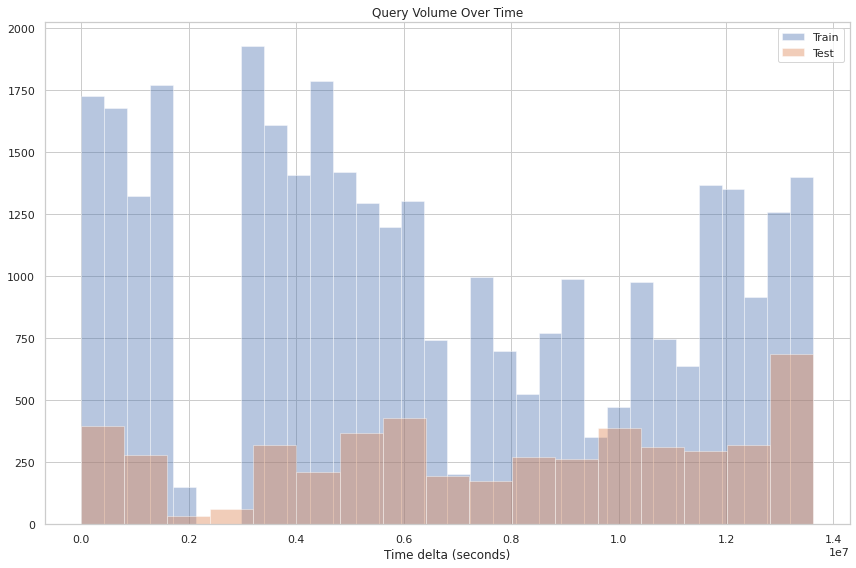

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
sns.distplot(train.time_delta, label='Train', kde=False, ax=axes)
sns.distplot(test.time_delta, label='Test', kde=False, ax=axes)
plt.title('Query Volume Over Time')
plt.xlabel('Time delta (seconds)')
plt.legend()
plt.tight_layout()

Both training and test sets span the same time period.
One thing that comes to mind is how the data are split - if training data is older than test data this will be important during cross validation.

### Numeric Feature Analysis

In [14]:
train.describe()

,user,time_delta,rank,serp,hour,dwell,new-sub,premium-pack,psrel,#cpv45
count,3.300000e+04,3.300000e+04,33000.000000,33000.000000,33000.000000,33000.000000,33000.000000,33000.000000,33000.000000,33000.000000
mean,1.407720e+09,6.435844e+06,33.001697,2.125667,11.576848,73.164091,0.796818,0.189970,0.059455,1.597727
std,6.387214e+08,4.152267e+06,106.874572,5.116320,3.360440,197.610658,0.402373,0.392283,0.236477,1.547953
min,8.438057e+06,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.260350e+09,3.350438e+06,2.000000,1.000000,9.000000,3.000000,1.000000,0.000000,0.000000,1.000000
50%,1.581158e+09,5.604960e+06,7.000000,1.000000,11.000000,11.000000,1.000000,0.000000,0.000000,1.000000
75%,1.855714e+09,1.037987e+07,25.000000,1.000000,14.000000,42.000000,1.000000,0.000000,0.000000,2.000000
max,2.358658e+09,1.362076e+07,5224.000000,262.000000,23.000000,2678.000000,1.000000,1.000000,1.000000,45.000000


The max values for **rank, serp, and dwell** suggest there are some outliers in the set; but they might be useful here - someone spending 44 mins inspecting a document would surely suggest it is relevant. Likewise it seems highly unlikely than a document with a rank > 100 is relevant. This requires further analysis.

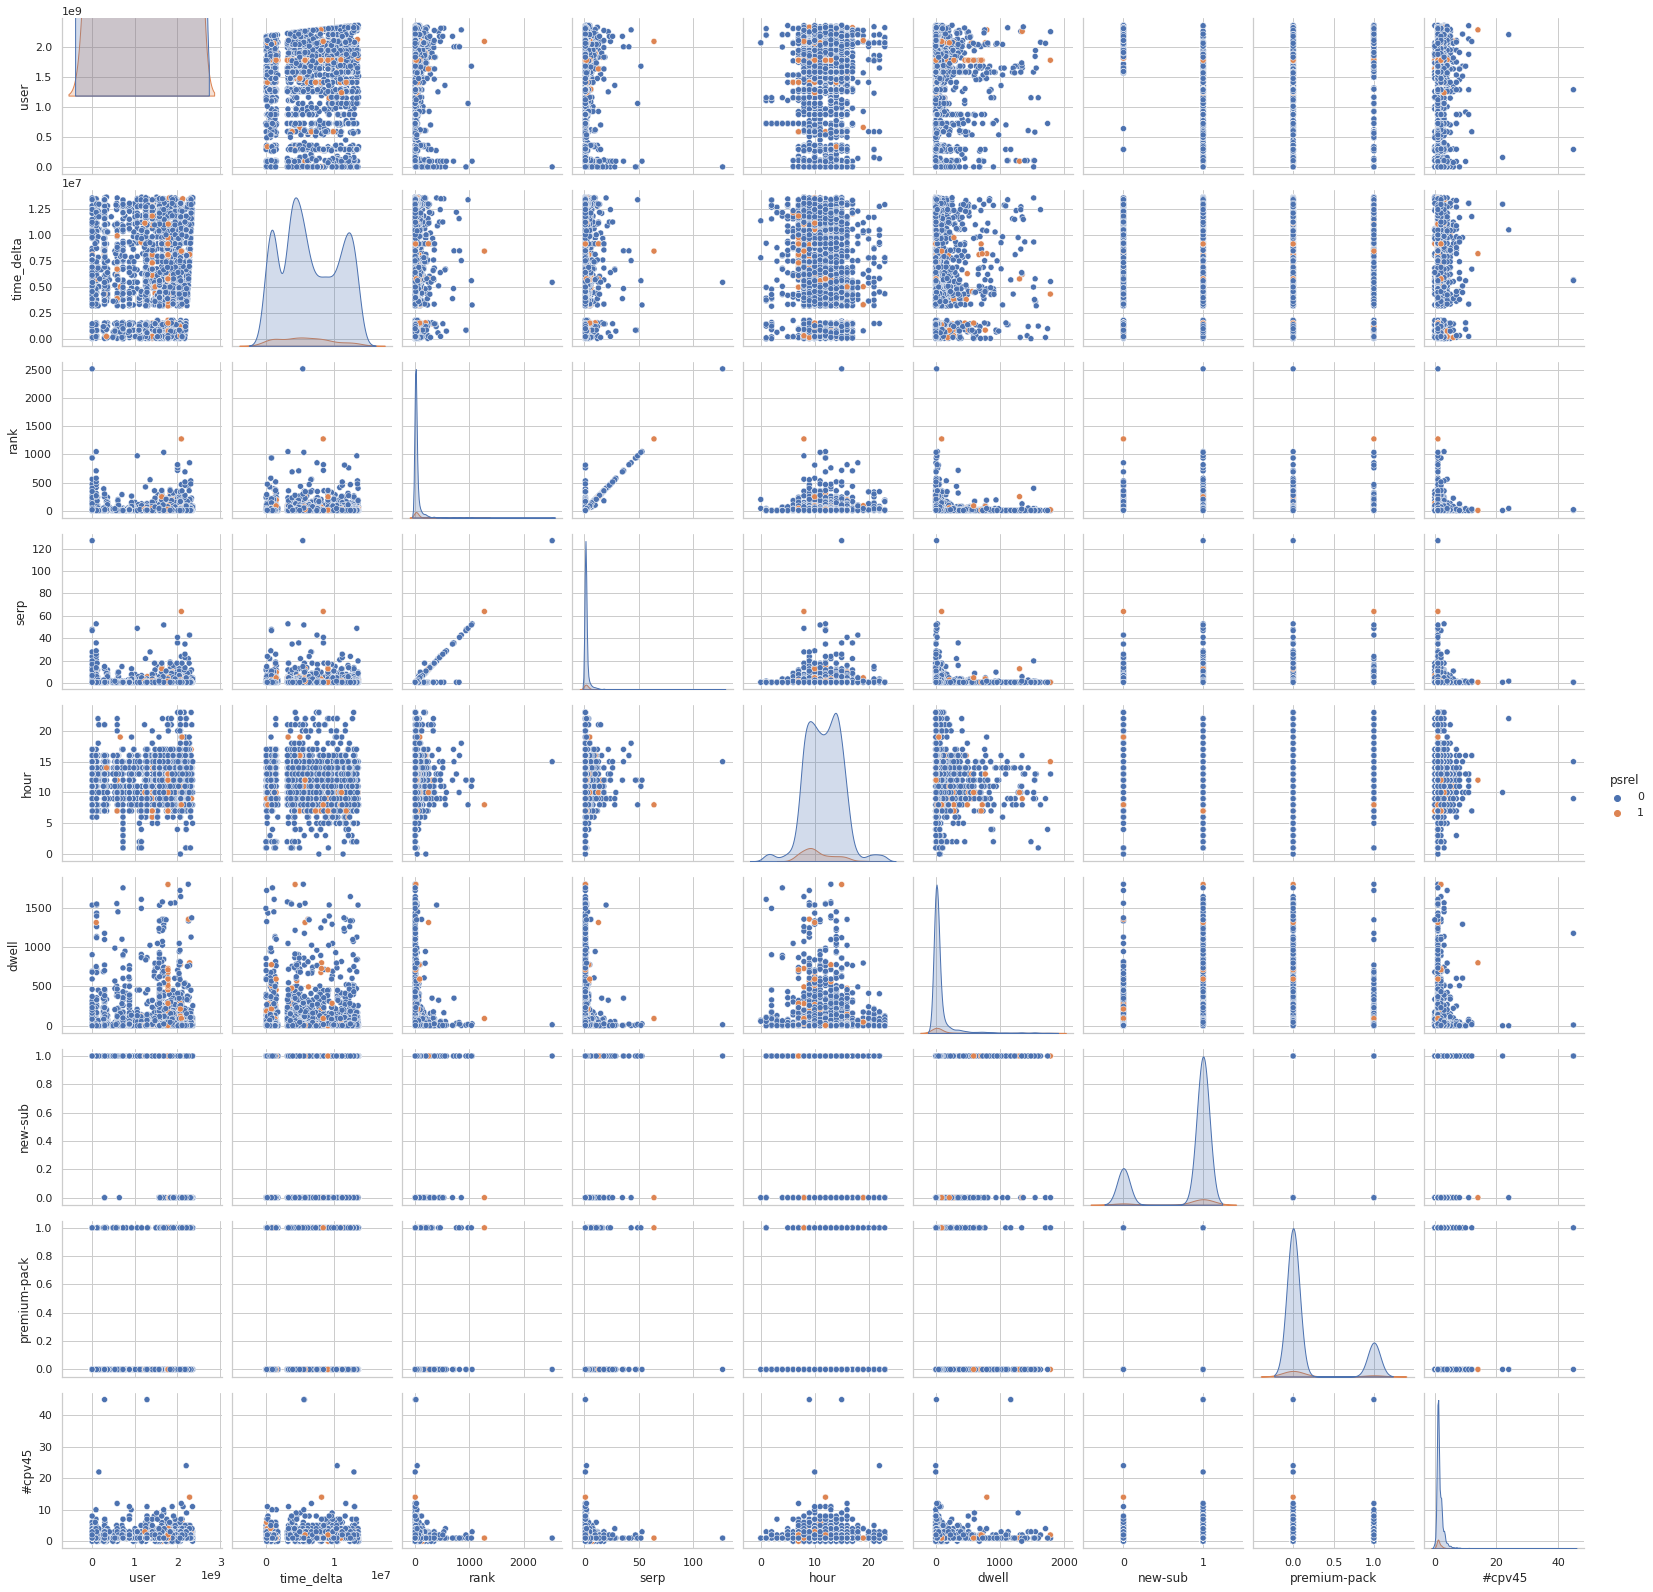

In [15]:
# Random sample (10% of set) of numeric data
numeric_sample = train.select_dtypes(include=np.number).sample(frac=0.1, random_state=seed)

sns.pairplot(numeric_sample, hue='psrel')

Observations:
* *Most important - there is no clear indicator of relevance here. Should be pretty tough trying to build a good classifier.*
* As you would expect, there is clearly multicollinearity introduced by **serp** and **rank** since they both increase with relevance. **Serp** can be dropped since it has less granularity than **rank**.
* There are quite a few heavily positively skewed variables with long tails `[rank, dwell, serp, #cpv45]`. Log transformation should hopefully bring these closer towards Gaussian distributions.
* **new-sub** and **premium-pack** have binomial distributions that mirror one another. This also tells us most users (~80%) are new to the service while ~20% of users are subscribed the premium pack with additional features. Should check for multicollinearity here too in case almost every 'experienced' user decides to use the business' premium features.

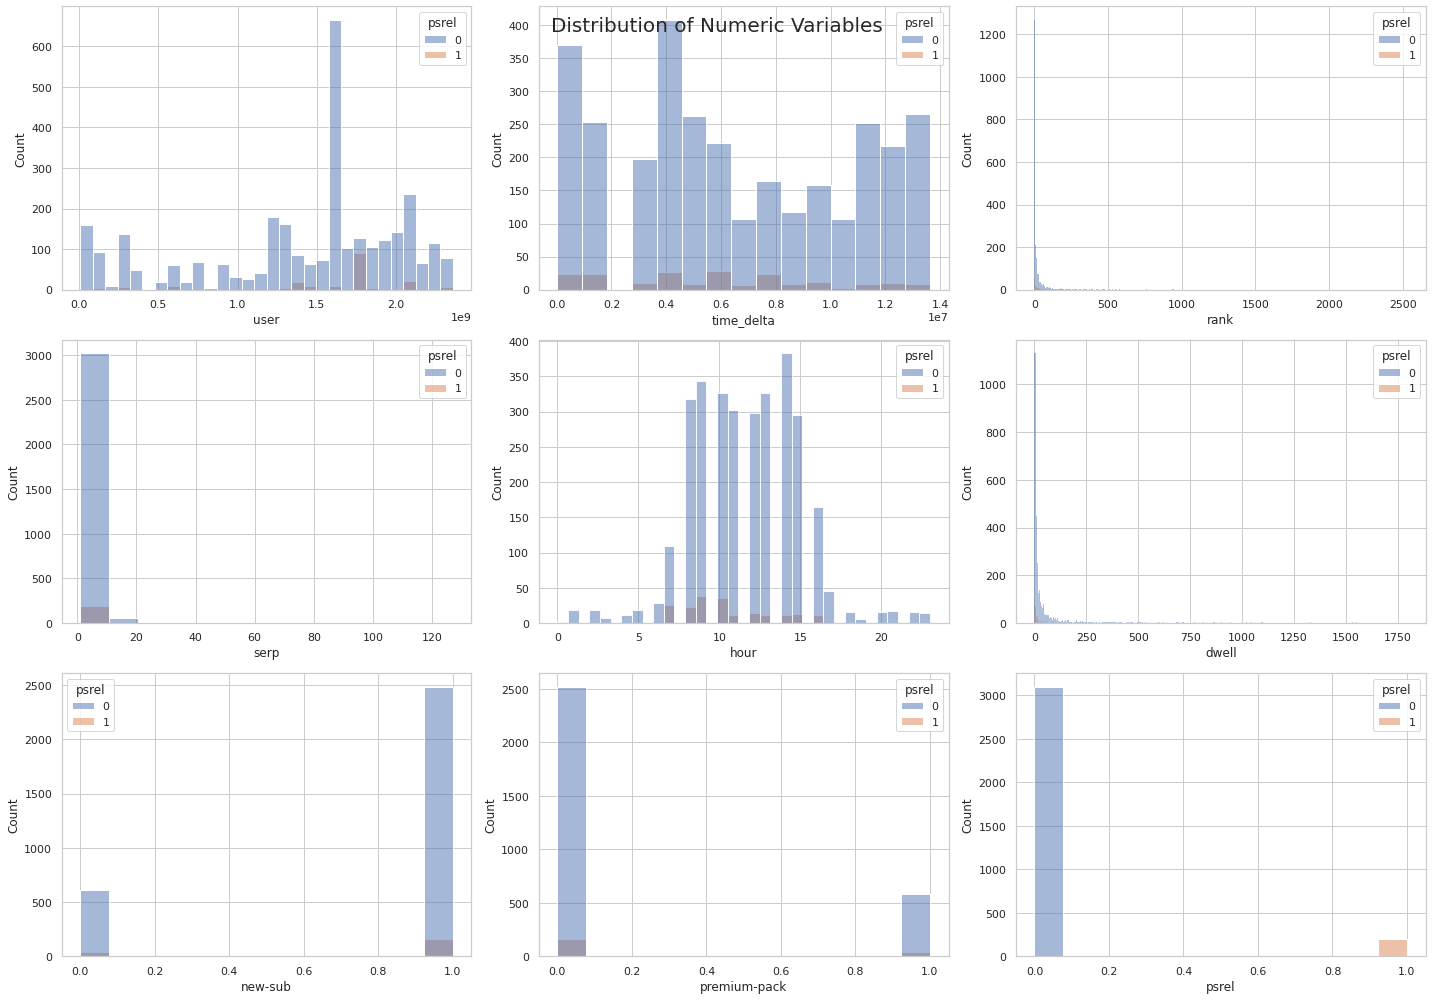

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(20, 14))
for (ax, col) in zip(axes.flatten(), numeric_sample.columns):
    sns.histplot(data=numeric_sample, hue='psrel', x=col, ax=ax)
fig.suptitle('Distribution of Numeric Variables\n', fontsize=20)
plt.tight_layout()
plt.show()

### Outlier Analysis

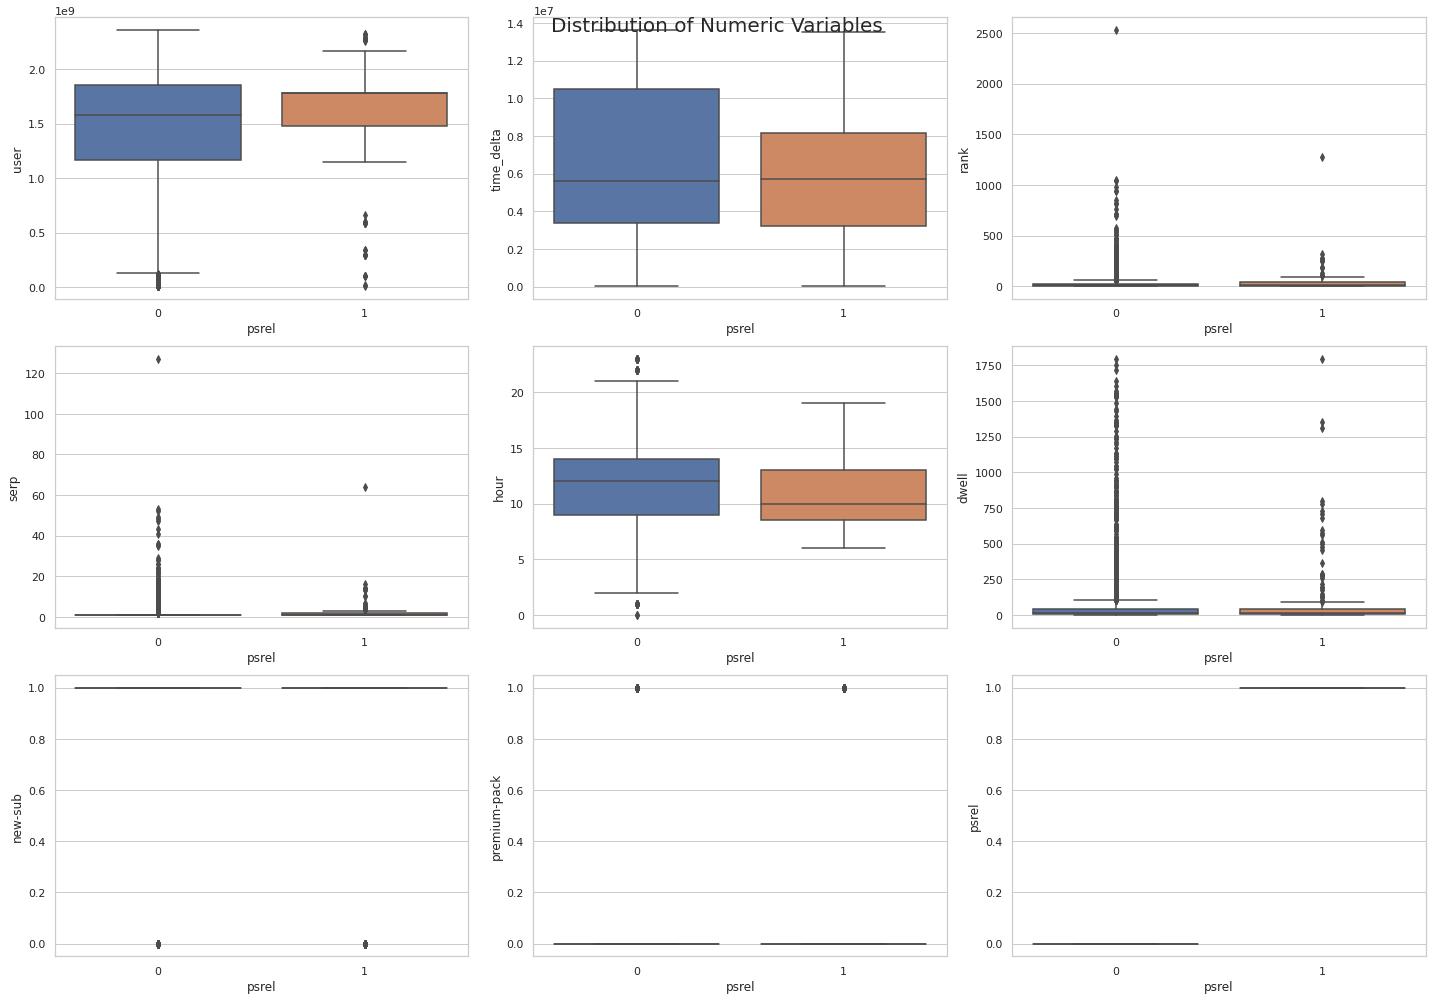

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(20, 14))
for (ax, col) in zip(axes.flatten(), numeric_sample.columns):
    sns.boxplot(data=numeric_sample, x='psrel', y=col, ax=ax)
fig.suptitle('Distribution of Numeric Variables\n', fontsize=20)
plt.tight_layout()
plt.show()

Consider dropping ['hour', '#cpv45'] as there is practically no difference with respect to the target.

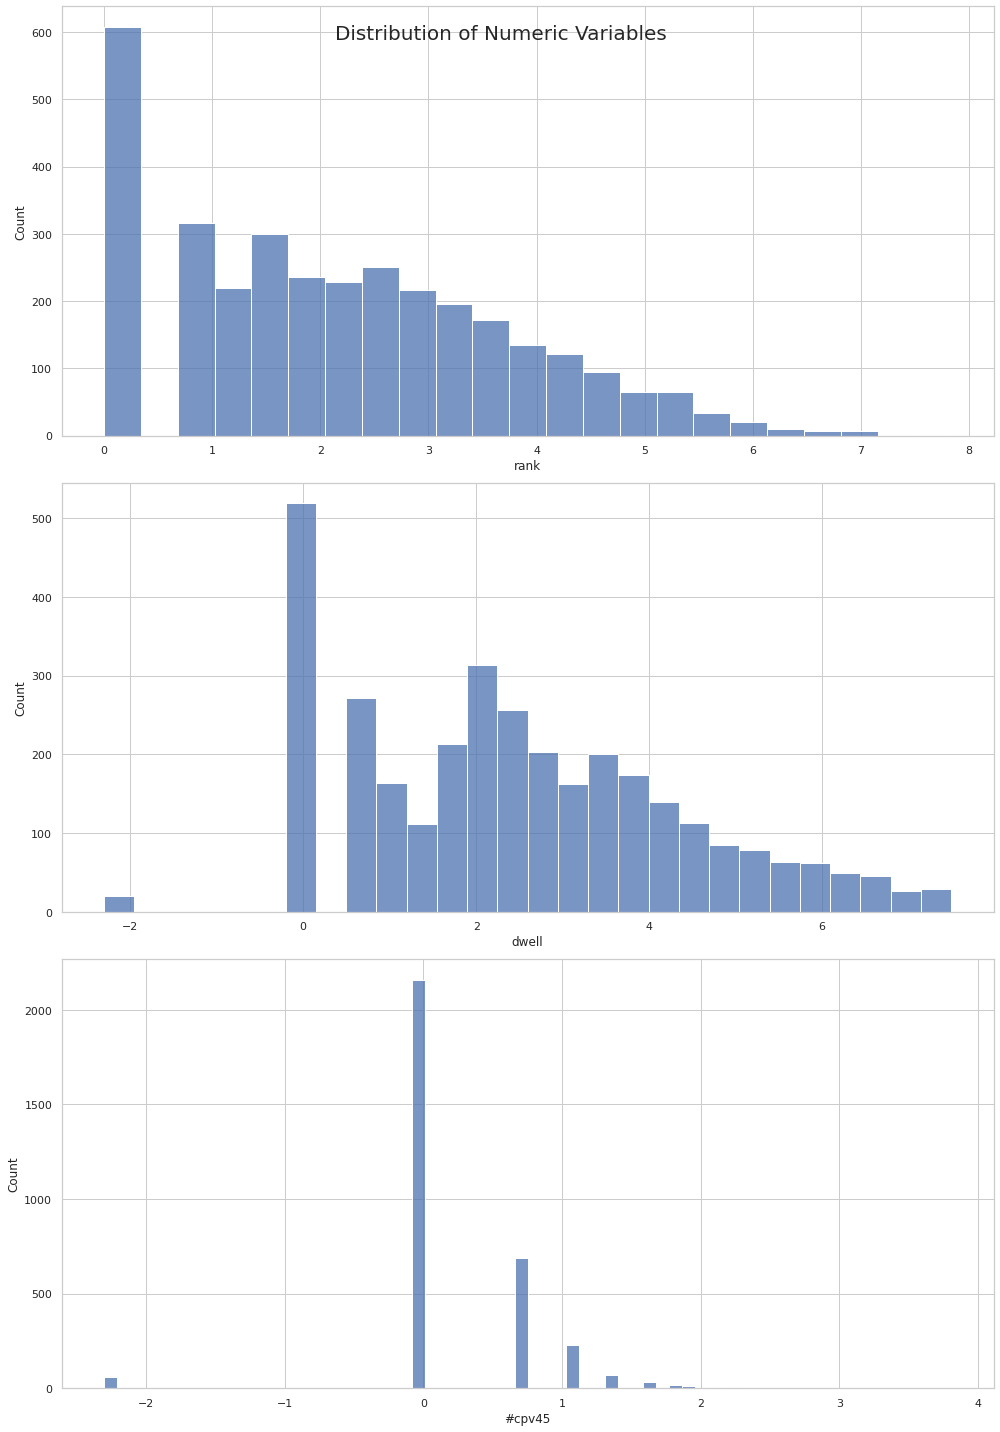

In [18]:
# Log transform of skewed features
skewed = numeric_sample[['rank',  'dwell', '#cpv45', 'psrel']].copy()

# Need to replace zeros with a small number to plot log transform
for col in skewed.columns[:-1]:
    skewed[col] = np.where(skewed[col] > 0, skewed[col], 0.1)  # replace 0 with 0.1

fig, axes = plt.subplots(3, 1, figsize=(14, 20))
for (ax, col) in zip(axes.flatten(), skewed.columns[:-1]):
    sns.histplot(skewed[col].apply(np.log), ax=ax)
fig.suptitle('Distribution of Numeric Variables\n', fontsize=20)
plt.tight_layout()
plt.show()

Quite a lot of users only spent 1 second looking at the document. Maybe these rows should be dropped.

In [19]:
train.groupby('psrel')['dwell'].describe()

,count,mean,std,min,25%,50%,75%,max
psrel,,,,,,,,
0,31038.0,72.638411,197.453060,0.0,3.0,11.0,42.0,2678.0
1,1962.0,81.480122,199.954334,0.0,4.0,13.0,47.0,1792.0


Doesn't surface anything we couldn't already see in the pairplot - some binomial distributions and some skewed. Try log transformation and consider dropping outliers or even the skewed featues themselves neither helps. 

Interesting that "dwell" has a higher range of values for *non relevant* entries. Users spent more time looking at non relevant?

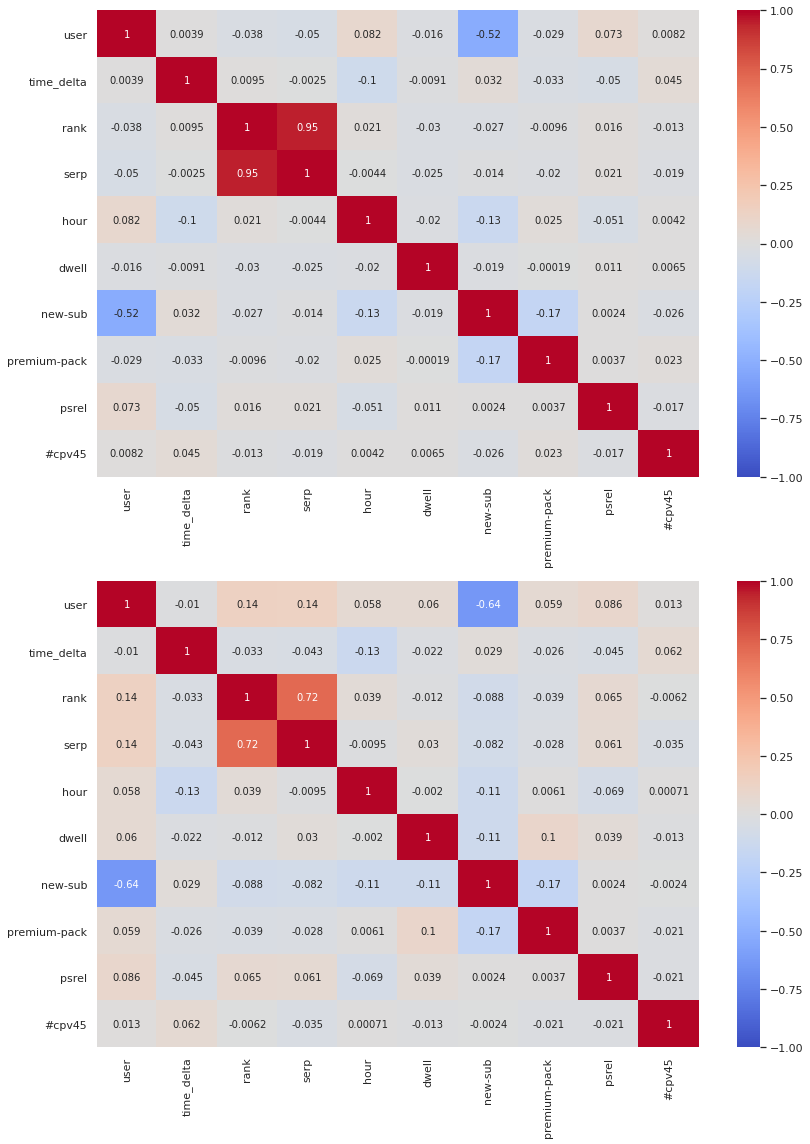

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12,16))
sns.heatmap(train.corr(method='pearson'), vmin=-1, cmap='coolwarm', annot=True, ax=ax1)
sns.heatmap(train.corr(method='spearman'), vmin=-1, cmap='coolwarm', annot=True, ax=ax2)
plt.tight_layout()

Feel like it's gonna take a neural net to find a relationship here, there really doesn't seem to be any clear predictor of relevance.

Worth noting the fairly high negative correlation between user ID and new-sub. Don't know how user IDs were generated so I don't know how to read into this; but we will probably drop user ID anyway so wouldn't worry about it.

### Categorical Feature Analysis

In [21]:
# Random sample (10% of set) of categorical data
categorical_sample = train.select_dtypes(include=np.object).sample(frac=0.1, random_state=seed)

In [22]:
# Exludes features with many categories
categorical_subset = ['nature']

for col in categorical_sample.columns:
    try:
        if len(np.unique(categorical_sample[col])) < 10:
            categorical_subset.append(col)
    except:
        continue

categorical_subset.append('psrel')

In [23]:
#fig, axes = plt.subplots(3, 2, figsize=(24, 15))
#for (ax, col) in zip(axes.flatten(), categorical_subset[:-1]):
#    sns.countplot(data=train[categorical_subset], x=col, hue='psrel', ax=ax)
#fig.suptitle('Counts of Categorical Variables\n', fontsize=20)
#plt.tight_layout()
#plt.show()

The only category which apppears to have a notable ratio of relevant to irrelevant documents is the 'advanced' category for the **search** feature. Perhaps the same can be said for 'noitce' within **type**, but once again there do not appear to be any clear predictors of relevance.

# Data Preprocessing


Firstly we dorp the undesired columns, purne the outliers, and one hot encode the remaining categorical data.

In [24]:
train.rename(columns={'#cpv45':'cpv45'}, inplace=True)

In [25]:
train.head(10)

,user,session,query,timestamp,timestamp_dt,time_delta,search,rank,serp,hour,day,month,dwell,new-sub,premium-pack,psrel,source,type,nature,cpvs,cpv45
0,8438057,A311E564F0A79803FB564CEAB6D7499A,d4fe169251f77f0800245e2df8376856,2020-05-26 10:45:36,2020-05-26 10:45:36,10948730.0,quick,1,1,10,Tue,May,1,1,0,0,Intercon,notice,services,"['66131100', '66141000', '66519600', '66520000']",1
1,8438876,5E91CF19B8BEBA58A90E54EC97AAB3AF,5066bca0a00273cf3925b0c2f260f763,2020-01-21 10:47:51,2020-01-21 10:47:51,62465.0,saved,75,8,10,Tue,Jan,10,1,0,0,Contrax Weekly,notice,services,"['79421000', '92520000', '92521000']",2
2,922102585,7D717BA805FB42D51D6C8EC15C0DE2C1,174e0e6c62fd5d7b044dd05b47ce79c9,2020-02-05 09:37:42,2020-02-05 09:37:42,1354256.0,advanced,4,1,9,Wed,Feb,21,1,0,0,Contrax Weekly,notice,services,"['79421000', '92520000', '92521000']",2
3,2105483652,D4855E55686DB80328B141598E3174CE,0f9f7f67dc569a6e3dba1ef35ce8970a,2020-01-21 14:43:57,2020-01-21 14:43:57,76631.0,advanced,66,4,14,Tue,Jan,21,0,0,0,Contrax Weekly,notice,services,"['79421000', '92520000', '92521000']",2
4,8438876,5E91CF19B8BEBA58A90E54EC97AAB3AF,5066bca0a00273cf3925b0c2f260f763,2020-01-21 10:48:33,2020-01-21 10:48:33,62507.0,saved,81,9,10,Tue,Jan,20,1,0,0,Contrax Weekly,notice,services,"['72000000', '72263000', '72300000']",1
5,2105483652,D4855E55686DB80328B141598E3174CE,0f9f7f67dc569a6e3dba1ef35ce8970a,2020-01-21 14:45:26,2020-01-21 14:45:26,76720.0,advanced,70,4,14,Tue,Jan,69,0,0,0,Contrax Weekly,notice,services,"['72000000', '72263000', '72300000']",1
6,8438876,5E91CF19B8BEBA58A90E54EC97AAB3AF,5066bca0a00273cf3925b0c2f260f763,2020-01-21 10:52:46,2020-01-21 10:52:46,62760.0,saved,115,12,10,Tue,Jan,12,1,0,0,Contracts Finder,notice,services,"['73000000', '77000000', '90000000']",3
7,8438876,5E91CF19B8BEBA58A90E54EC97AAB3AF,775373880d0654f18a10e8b2621046dc,2020-01-21 11:05:59,2020-01-21 11:05:59,63553.0,saved,1,1,11,Tue,Jan,20,1,0,0,Contracts Finder,notice,services,['85000000'],1
8,8438876,5E91CF19B8BEBA58A90E54EC97AAB3AF,775373880d0654f18a10e8b2621046dc,2020-01-21 11:06:41,2020-01-21 11:06:41,63595.0,saved,11,2,11,Tue,Jan,13,1,0,0,Contrax Weekly,notice,services,"['73000000', '73200000']",1
9,365820953,FB03C905BA38DAC1D90822859E480DC7,9421b6daa78871a6e786077c4788d61c,2020-01-21 13:07:02,2020-01-21 13:07:02,70816.0,saved,22,2,13,Tue,Jan,69,1,0,0,Contrax Weekly,notice,services,"['73000000', '73200000']",1


In [26]:
#Functions to drop, prune, and encode dataset
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

#made the one hot encoder able to handle unknown data, which will be useful in our testing section with
#unknown users

def drop(df,drop_list=[]):
    for i in drop_list:
        if i in df.columns:
            df=df.drop(i, axis=1)
    return df

def prune(df,outliers=dict()):
    for i in outliers:
        df=df.loc[lambda df: df[i]<=outliers[i]]
    return df

def one_hot_enc(dfA,dfB,one_hot=[],inc=False):    
    for i in one_hot:
        if i in dfA.columns and i in dfB.columns:
            cat_1hotfit = cat_encoder.fit(dfA[[i]])
            cat_1hot = cat_encoder.transform(dfB[[i]])#
            categories = cat_encoder.categories_
            enc_data = pd.DataFrame(cat_1hot)
            enc_data.columns = categories[0]
            enc_data.index = dfB.index
            if inc==False:
                dfB=pd.concat([dfB,enc_data.iloc[: , 1:]], axis=1, ignore_index=False)
                dfB=dfB.drop(i, axis=1)
            else:
                dfB=pd.concat([dfB,enc_data], axis=1, ignore_index=False)
                dfB=dfB.drop(i, axis=1)
    return dfB

In [27]:
drop_list=['timestamp_dt','time_delta','session',"timestamp","hour","day","month","cpvs","query"]
user=drop(train,drop_list)

outliers=dict()
outliers["rank"]=500
outliers["serp"]=60
outliers["dwell"]=750
outliers["cpv45"]=20

userp=prune(user,outliers)

one_hot=['user','search','type','nature','source']
user=one_hot_enc(userp,userp,one_hot)

print(user.shape)


(32055, 1189)


## Test:Train Split and Scale the data

In [28]:
#Splitting the data into x and y dor inputs and labels
X_user , y_user = user.drop('psrel', axis=1),user['psrel']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#with username
X1_train_full, X1_test, y1_train_full, y1_test = train_test_split(X_user, y_user,test_size=0.2)
X1_train, X1_valid, y1_train, y1_valid = train_test_split(X1_train_full, y1_train_full,test_size=0.2)

scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_valid = scaler.transform(X1_valid)
X1_test = scaler.transform(X1_test)

In [29]:
y2_test=pd.DataFrame(y1_test, columns=['psrel'])
y2_train=pd.DataFrame(y1_train, columns=['psrel'])
y2_valid=pd.DataFrame(y1_valid, columns=['psrel'])

#y2 needed for the softmax outputs rather than the sigmoid
y2_test=one_hot_enc(y2_test,y2_test,['psrel'],inc=True)
y2_train=one_hot_enc(y2_train,y2_train,['psrel'],inc=True)
y2_valid=one_hot_enc(y2_valid,y2_valid,['psrel'],inc=True)

In [30]:
print('Train: {}, Test: {}'.format(sum(y1_train_full),sum(y1_test)))
#we only have ~1000 'true' examples in our training set and another 1000 in out testing subset...

Train: 1538, Test: 366


In [31]:
#Create boolean arrays for the AdaBoost Classifier model
y1_train_bool=(y1_train==1)
y1_test_bool=(y1_test==1)